In [25]:
import os
import sys
import warnings
from enum import IntEnum
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.utils import io
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
with io.capture_output() as captured:

    import mbuild
    import MDAnalysis as mda
    import mdtraj
    import nglview
    import openmm
    from MDAnalysis.analysis import rms
    from openff import interchange, models, toolkit, utilities
    from openff.interchange.components._packmol import UNIT_CUBE, pack_box
    from openff.toolkit import topology
    from openff.units import unit

# Build

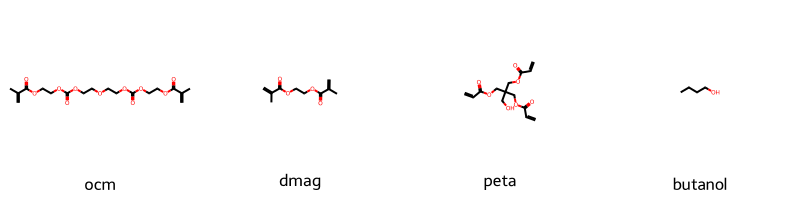

In [3]:
class MoleculesTypes(IntEnum):
    butanol = 0
    ocm = 1
    dmag = 2
    peta = 3


RD_MOLECULES = {
    MoleculesTypes.ocm: Chem.MolFromSmiles(
        "CC(C(OCCOC(OCCOCCOC(OCCOC(C(C)=C)=O)=O)=O)=O)=C"
    ),
    MoleculesTypes.dmag: Chem.MolFromSmiles("C=C(C)C(OCCOC(C(C)=C)=O)=O"),
    MoleculesTypes.peta: Chem.MolFromSmiles("C=CC(OCC(COC(C=C)=O)(COC(C=C)=O)CO)=O"),
    MoleculesTypes.butanol: Chem.MolFromSmiles("OCCCC"),
}

OFF_MOLECULES = {}
for molecule_type, rdkit_mol in RD_MOLECULES.items():
    mol = toolkit.Molecule.from_rdkit(rdkit_mol)
    OFF_MOLECULES[molecule_type] = mol
    mol.generate_conformers(n_conformers=1)
    mol.name = molecule_type.name

    for atom in mol.atoms:
        atom.metadata["residue_name"] = molecule_type.name.upper()
    mol.add_hierarchy_scheme(
        iterator_name="residue",
        uniqueness_criteria=["residue_name"],
    )

Draw.MolsToGridImage(
    RD_MOLECULES.values(),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in RD_MOLECULES.keys()],
)

In [6]:
class Box:
    box = None
    ff = toolkit.ForceField("openff_unconstrained-2.1.0.offxml")

    def __init__(self, x, rho, substance: MoleculesTypes):
        self.solvent_n = int(x)
        self.substance_n = int((100 - x))
        self.substance = substance
        self.rho = rho

    def __repr__(self) -> str:
        return f"<Box: {self.substance}= {self.substance_n} ({self.solvent_n}), rho={self.rho} mg/cm3>"

    def pack(self, tol=0.5):
        solvent = OFF_MOLECULES[MoleculesTypes.butanol]
        substance = OFF_MOLECULES[self.substance]
        if self.substance_n == 0:
            molecules = [solvent]
            n_molecules = [100]
        elif self.substance_n == 100:
            molecules = [substance]
            n_molecules = [100]
        else:
            molecules = [solvent, substance]
            n_molecules = [self.solvent_n, self.substance_n]
        self.box = pack_box(
            molecules=molecules,
            number_of_copies=n_molecules,
            mass_density=self.rho * unit.kilogram / unit.meter**3,
            tolerance=tol * unit.angstrom,
            box_shape=UNIT_CUBE,
        )

    def parametrize(self):
        self.system = interchange.Interchange.from_smirnoff(
            force_field=self.ff,
            topology=self.box,
        )

    def minimaze(self):
        self.system.minimize()

    def save(self, path):
        with open(path, "w") as file:
            box_j = self.box.to_json()
            data = {
                "solvent_n": self.solvent_n,
                "substance": self.substance,
                "rho": self.rho,
            }
            box_j = f"{data} ###" + box_j
            file.write(box_j)

    @classmethod
    def load(cls, path):
        with open(path, "r") as file:
            box_j = file.read()
            data, box_j = box_j.split("###")
            data = eval(data)
            box = Box(
                x=int(data["solvent_n"]),
                rho=data["rho"],
                substance=data["substance"],
            )
            box.box = toolkit.Topology.from_json(box_j)

        return box

In [12]:
res = {
    "butanol": [
        (100, 1000),
    ],
    "dmag": [
        (0, 1069),
        (11, 1069),
        (22, 1050),
        (35, 1029),
        (39, 1019),
    ],
    "ocm": [
        (0, 1720),
        (12, 1580),
        (22, 1569),
        (31, 1550),
        (38, 1539),
        (44, 1530),
        (49, 1510),
        (54, 1489),
        (58, 1490),
    ],
    "peta": [
        (0, 1200),
        (19, 1180),
        (30, 1159),
        (41, 1140),
        (49, 1110),
    ],
}

In [44]:
boxes = []
for substance, combinations in res.items():
    for x, rho in combinations:
        box = Box(
            x=x,
            rho=rho,
            substance=substance,
        )
        try:
            box.pack(tol=1)
            box.save(path=f"./boxes/box_{substance}_{x}_{rho}.json")
        except:
            pass

        try:
            box.pack(tol=0.5)
            box.save(path=f"./boxes/box_{substance}_{x}_{rho}.json")
        except:
            continue

boxes

[]

In [7]:
b = Box.load("boxes/box_butanol_100_1000.json")
with io.capture_output() as captured:
    view = b.box.visualize()
# view

In [8]:
b.parametrize()

In [9]:
b.minimaze()

# Simulation

In [42]:
def simulate(
    box: Box,
    T=25,
    save_dir: Path = Path("simulations"),
):
    trj_freq = 10
    # Integration options
    time_step = 2 * openmm.unit.femtoseconds  # simulation timestep
    temperature = (T + 273) * openmm.unit.kelvin  # simulation temperature
    friction = 1 / openmm.unit.picosecond  # friction constant

    integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

    sim = box.system.to_openmm_simulation(integrator=integrator)
    sim.context.setVelocitiesToTemperature(temperature)
    substance = box.substance
    x = box.substance_n
    rho = box.rho

    sim_dir = save_dir/Path(f"box_{substance}_{x}_{rho}")
    sim_dir.mkdir(parents=True, exist_ok=True)
    box.system.to_pdb( f"{sim_dir}/box_min.pdb")
    reporters = [
        openmm.app.StateDataReporter(sys.stdout, trj_freq*100, step=True),
        openmm.app.DCDReporter(
            f"{sim_dir}/traj.dcd",
            trj_freq,  # enforcePeriodicBox=False,
        ),
    ]
    sim.reporters.extend(reporters)
    return sim, save_dir / sim_dir

In [41]:
sim, traj_path = simulate(b)
sim.step(10000)

#"Step"
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


# Results

In [43]:
class Traj:
    def __init__(self,folder_path:Path):
        self.system = mda.Universe(f"{folder_path}/box_min.pdb", f"{folder_path}/traj.dcd")

In [44]:
u = Traj(
    'simulations/box_butanol_0_1000'
)

In [46]:
universe =u.system

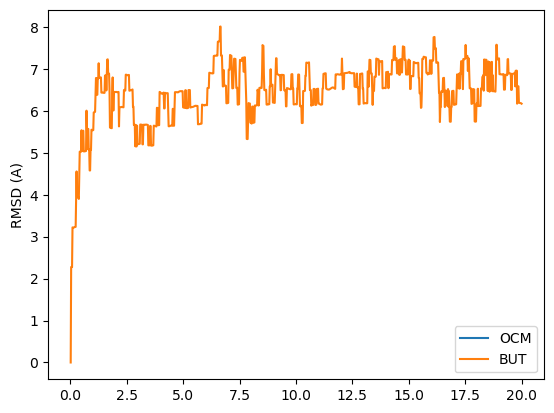

In [47]:
r_ocm = rms.RMSD(universe, universe, "resname OCM")
r_ocm.run()
df_ocm = pd.DataFrame(r_ocm.results.rmsd, columns=["Frame", "Time", "OCM"])

r_but = rms.RMSD(universe, universe, "resname BUT")
r_but.run()
df_but = pd.DataFrame(r_but.results.rmsd, columns=["Frame", "Time", "BUT"])

fig, ax = plt.subplots()
ax.plot(df_ocm["Time"], df_ocm["OCM"], label="OCM")
ax.plot(df_but["Time"], df_but["BUT"], label="BUT")
ax.set_ylabel("RMSD (A)")
ax.legend()

In [49]:
import numpy as np

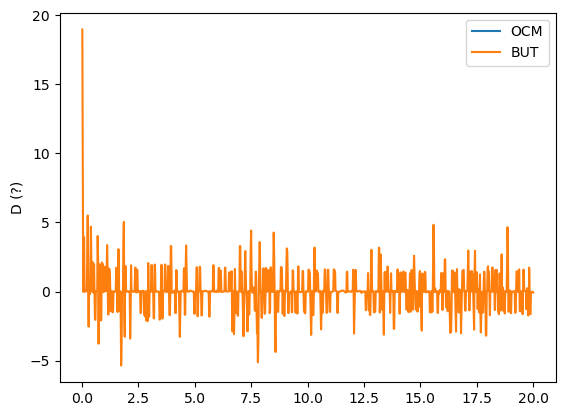

In [50]:
# ocm
x = df_ocm["Time"]
y = df_ocm["OCM"]
d = np.gradient(y, x) / 6

fig, ax = plt.subplots()
ax.plot(x, d, label="OCM")

x = df_but["Time"]
y = df_but["BUT"]
d = np.gradient(y, x) / 6

ax.plot(x, d, label="BUT")
ax.set_ylabel("D (?)")

ax.legend()